In [1]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
from operator import xor
import readFloatsFile
from JidtWrapper import JidtWrapper, np2JArr

# Create a TE wrapper class
jidtWrapper1 = JidtWrapper()

### Analytical transfer entropy:

* $T(A\rightarrow B) = I(Y_t ; X_{t \in [-1, -L]} | Y_{t \in [-1, -L]})$
  - The information shared by current Y, and history of X of length L, given that the history of Y of length L is known

Additional concepts
* https://github.com/jlizier/jidt

In [2]:
# Shift all elements of the array to the right cyclically
def cyclicShift(arr, num):
    return np.hstack((arr[-num:], arr[:-num]))

# Shift all elements of the array to the right, replacing them with zeros
def lossyShift(arr, num):
    return np.hstack(([0]*num, arr[:-num]))

aaa = np.linspace(1, 10, 10)
print("original array:      ", aaa)
print("lossy-shifted by 2:  ", lossyShift(aaa, 2))
print("cyclic-shifted by 2: ", cyclicShift(aaa, 2))

original array:       [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
lossy-shifted by 2:   [0. 0. 1. 2. 3. 4. 5. 6. 7. 8.]
cyclic-shifted by 2:  [ 9. 10.  1.  2.  3.  4.  5.  6.  7.  8.]


### Effect of History

In [45]:
# Generate some random binary data.
sourceArray1 = np.random.randint(0, 2, 100)
sourceArray2 = np.random.randint(0, 2, 100)
destArray1 = lossyShift(sourceArray1, 1).astype(int)
destArray2 = lossyShift(sourceArray1, 2).astype(int)

# Create a TE calculator and run it:
print('----- DISCRETE ---------------')
param = {'historyLength' : 2, 'kernelWidth' : 1}
te_random = jidtWrapper1.calcTwoPartiteTE_Discrete(sourceArray2, destArray1, param)
te_lag_1 = jidtWrapper1.calcTwoPartiteTE_Discrete(sourceArray1, destArray1, param)
te_lag_2 = jidtWrapper1.calcTwoPartiteTE_Discrete(sourceArray1, destArray2, param)
te_lag_1_rev = jidtWrapper1.calcTwoPartiteTE_Discrete(destArray1, sourceArray1, param)
te_lag_2_rev = jidtWrapper1.calcTwoPartiteTE_Discrete(destArray2, sourceArray1,param)

print("Uncorrelated: %.4f" % te_random)
print("1 step lag  : %.4f" % te_lag_1)
print("2 step lag  : %.4f" % te_lag_2)
print("1 step lag, backwards  : %.4f" % te_lag_1_rev)
print("2 step lag, backwards  : %.4f" % te_lag_1_rev)

sourceArray1 = sourceArray1.astype(float)
sourceArray2 = sourceArray2.astype(float)
destArray1 = destArray1.astype(float)
destArray2 = destArray2.astype(float)

print('----- TE_KERNEL ---------------')
paramKernel = {'method': 'TE_KERNEL', 'initParam': [2, 0.5], 'properties': {"NORMALISE" : "true"}}
te_random = jidtWrapper1.runJavaTwoPartite((sourceArray2, destArray1), paramKernel)
te_lag_1 = jidtWrapper1.runJavaTwoPartite((sourceArray1, destArray1), paramKernel)
te_lag_2 = jidtWrapper1.runJavaTwoPartite((sourceArray1, destArray2), paramKernel)
te_lag_1_rev = jidtWrapper1.runJavaTwoPartite((destArray1, sourceArray1), paramKernel)
te_lag_2_rev = jidtWrapper1.runJavaTwoPartite((destArray2, sourceArray1),paramKernel)

print("Uncorrelated: %.4f" % te_random)
print("1 step lag  : %.4f" % te_lag_1)
print("2 step lag  : %.4f" % te_lag_2)
print("1 step lag, backwards  : %.4f" % te_lag_1_rev)
print("2 step lag, backwards  : %.4f" % te_lag_1_rev)


----- DISCRETE ---------------
Uncorrelated: 0.0127
1 step lag  : 0.9731
2 step lag  : 0.0516
1 step lag, backwards  : 0.0212
2 step lag, backwards  : 0.0212
----- TE_KERNEL ---------------
Uncorrelated: 0.0119
1 step lag  : 0.9504
2 step lag  : 0.0770
1 step lag, backwards  : 0.0000
2 step lag, backwards  : 0.0000


# Effect of correlation strength

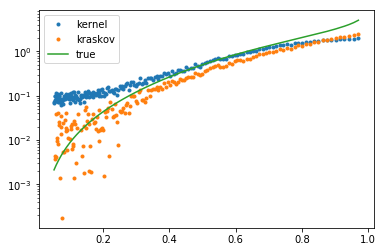

In [26]:
# Generate some random normalised data.
numObservations = 1000
discr = 200

covLst = 20**(np.linspace(0.01, 0.99, discr) - 1)  # Sample more the small correlations than the big ones
rezKernel = np.zeros(discr)
rezKraskov = np.zeros(discr)
rezTrue = np.zeros(discr)

for i in range(discr):
    cov = covLst[i]
    
    # Normal random source
    sourceArray  = np.random.normal(0.01, 1, numObservations)
    
    # Destination array of random normals with partial correlation to previous value of sourceArray
    destArray = np.zeros(numObservations)
    destArray[1:] += cov * sourceArray[:-1]
    destArray[1:] += (1 - cov) * np.random.normal(0, 1, numObservations-1)

    # Normalise the individual variables
    # Use history length 1 (Schreiber k=1), kernel width of 0.5 normalised units
    paramKernel = {'method': 'TE_KERNEL', 'initParam': [1, 0.5], 'properties': {"NORMALISE" : "true"}}
    paramKraskov = {'method': 'TE_KRASKOV', 'initParam': [1], 'properties': {"NORMALISE": "true", "k": "4"}}
    rezKernel[i] = jidtWrapper1.runJavaTwoPartite((sourceArray, destArray), paramKernel)
    rezKraskov[i] = jidtWrapper1.runJavaTwoPartite((sourceArray, destArray), paramKraskov)

#     corr_expected = cov / np.sqrt(cov**2 + (1-cov)**2)
#     rezTrue[i] = -0.5*np.log2(1-corr_expected**2)

    corr_expected = cov / (1 * math.sqrt(cov**2 + (1-cov)**2));
    rezTrue[i] = -0.5*math.log(1-math.pow(corr_expected,2))/math.log(2)
    
plt.figure()
plt.semilogy(covLst, rezKernel, '.', label='kernel')
plt.semilogy(covLst, rezKraskov, '.', label='kraskov')
plt.semilogy(covLst, rezTrue, label='true')
plt.legend()
plt.show()